In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sc
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from IPython.display import display
%matplotlib inline

In [2]:
# read in data
raw_loan_data = pd.read_csv('loan.csv')

In [3]:
# filter for relevant columns
relevant_cols = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
save filtered data to avoid reading large raw data file again
raw_loan_data[relevant_cols].to_csv('filtered_loan_data.csv', index = False)

In [4]:
# read in filtered data
filtered_loan_data = pd.read_csv('filtered_loan_data.csv')

# Part 1: Data Exploration and Evaluation

Part 1 consists of four sections:

#### Section 1A: Handling Missing Values
#### Section 1B: Exploring Categorical Variables - Transformations
#### Section 1C: Exploring Numerical Variables - Managing Outliers
#### Section 1D: Cross Variable Exploration

#### Section 1A: Handling Missing Values

In [5]:
# preview filtered data
filtered_loan_data.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,2500,2500,36 months,13.56,C,55000.0,Dec-2018,18.24,4341,167.02,Current
1,30000,30000,60 months,18.94,D,90000.0,Dec-2018,26.52,12315,1507.11,Current
2,5000,5000,36 months,17.97,D,59280.0,Dec-2018,10.51,4599,353.89,Current
3,4000,4000,36 months,18.94,D,92000.0,Dec-2018,16.74,5468,286.71,Current
4,30000,30000,60 months,16.14,C,57250.0,Dec-2018,26.35,829,1423.21,Current


In [6]:
# count of values by variable
filtered_loan_data.count()

loan_amnt      2260668
funded_amnt    2260668
term           2260668
int_rate       2260668
grade          2260668
annual_inc     2260664
issue_d        2260668
dti            2258957
revol_bal      2260668
total_pymnt    2260668
loan_status    2260668
dtype: int64

In [7]:
# a version of our dataset with no missing values
filtered_loan_data_no_missing = filtered_loan_data.dropna()
filtered_loan_data_no_missing.shape

(2258953, 11)

In [8]:
# missing values are less than 0.1% of data
(filtered_loan_data.shape[0] - filtered_loan_data_no_missing.shape[0]) / filtered_loan_data.shape[0] * 100

0.0758625326673355

Given the very low incidence (< 0.1%) of missing values, we can exclude them from the analysis. If missing values were of higher incidence, then we could impute them using a means or regression method.

#### Section 1B: Exploring Categorical Variables - Transformations

In [9]:
numerical_vars = filtered_loan_data_no_missing._get_numeric_data().columns.values
categorical_vars = list(filtered_loan_data_no_missing.columns.difference(numerical_vars))
categorical_vars

['grade', 'issue_d', 'loan_status', 'term']

In [10]:
# summary statistics on categorical variables
filtered_loan_data_no_missing[categorical_vars].describe()

,grade,issue_d,loan_status,term
count,2258953,2258953,2258953,2258953
unique,7,139,9,2
top,B,Mar-2016,Fully Paid,36 months
freq,663120,61979,1041702,1608745


The above summary statistics table suggests that grade, loan status and term are good candidates for conversion to dummy variables (given their relatively small number of unique values) while issue date is not (139 unique values). 

Issue date needs to be coded to capture the information its conveying, an indicator of months since issue. We additionally create two variables with issue date that may predict defaults - issued during recession and issued during the holidays. A loan issued during a recession may be more likely default due to declining asset values, rising unemployment, etc. A loan issued during the holidays (November and December) may be more likely to default as individuals may be more likely to make less financially sound purchases or spend beyond their budget during this period of increased consumption and may do so via credit.

In [11]:
# code grade, loan status and term as dummies
# we keep a copy of each categorical variable with a _CP to ease visualization / analysis
# in our logistic regression model we will have n-1 dummies for n categories but keep n for now for visualization purposes
filtered_loan_data_no_missing = filtered_loan_data_no_missing.copy()
filtered_loan_data_no_missing['grade_CP'] = filtered_loan_data_no_missing['grade']
filtered_loan_data_no_missing['term_CP'] = filtered_loan_data_no_missing['term']
filtered_loan_data_no_missing['loan_status_CP'] = filtered_loan_data_no_missing['loan_status']
filtered_loan_data_cat_fix_1 = pd.get_dummies(filtered_loan_data_no_missing, columns = ['grade', 'loan_status', 'term'])

In [12]:
# format issue date as datetime for subtraction
filtered_loan_data_cat_fix_1['issue_d_clean'] = pd.to_datetime(filtered_loan_data_cat_fix_1['issue_d'], format='%b-%Y')

In [13]:
today_date = datetime.date.today()

In [14]:
# create months since issue varriable
filtered_loan_data_cat_fix_1['months_since_issue'] = ((today_date - filtered_loan_data_cat_fix_1['issue_d_clean'])/np.timedelta64(1, 'M')).astype(int)

With the most recent recession in the US from 2007-2009, this variable = 1 if a loan is issued during this period and 0 otherwise for this data. In use of this model, this variable should be changed to 1 for subsequent years with recessions.

In [15]:
filtered_loan_data_cat_fix_1['year_is'] = filtered_loan_data_cat_fix_1['issue_d_clean'].map(lambda x: x.year)

In [16]:
filtered_loan_data_cat_fix_1['issued_during_recession'] = [1 if x in [2007, 2008, 2009] else 0 for x in filtered_loan_data_cat_fix_1['year_is']]

A loan issued during the holidays is one that is defined with an issue month of November or December

In [17]:
filtered_loan_data_cat_fix_1['month_is'] = filtered_loan_data_cat_fix_1['issue_d_clean'].map(lambda x: x.month)
filtered_loan_data_cat_fix_1['issued_during_holidays'] = [1 if x in [11,12] else 0 for x in filtered_loan_data_cat_fix_1['month_is']]

The distributions of categorical variabes below show that A,B,C grades and 36 month loans are most frequent in the data set. Furthermore, the most common loan statuses are fully paid or current. Finally, most loans in the data set have been issued in the past 5 years, with some far back reaching outliers

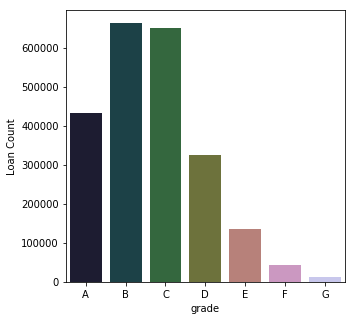

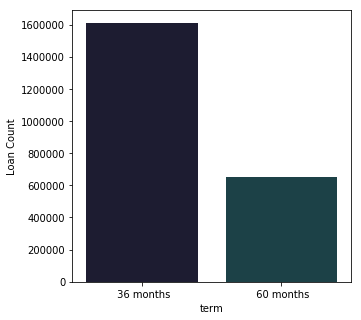

In [18]:
# category distributions for grade and term
# These show that A,B,C grades and 36 month loans are most frequent
for var in ['grade', 'term']:
    plt.figure(figsize = (5,5))
    sns.barplot(x=var, y='int_rate', data = filtered_loan_data.groupby(var)['int_rate'].count().reset_index(), palette = sns.color_palette("cubehelix", 8))
    plt.ylabel("Loan Count")

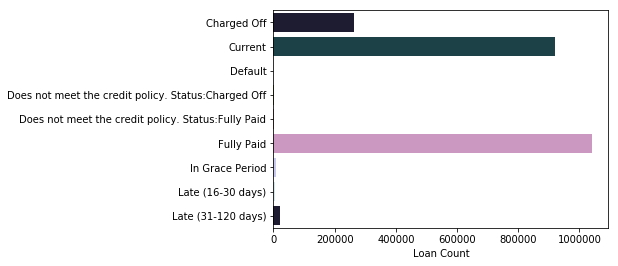

In [19]:
# category distribution for loan_status
# These show that majority of loans are fully paid or current
plt.figure()
sns.barplot(y='loan_status', x='int_rate', data = filtered_loan_data.groupby('loan_status')['int_rate'].count().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("")
plt.xlabel("Loan Count")

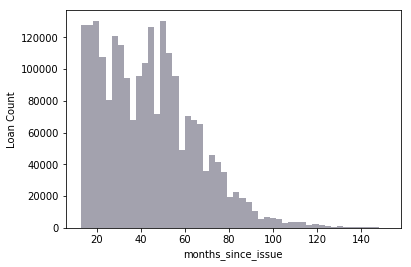

In [20]:
# distribution of months since issue - majority under 5 years with some far reaching outliers
sns.set_palette(palette = sns.color_palette("cubehelix", 8))
sns.distplot(filtered_loan_data_cat_fix_1['months_since_issue'], kde = False)
plt.ylabel("Loan Count")

A very small percentage (0.4%) of loans were issued during the recession, but we examine if this percentage is higher for the loans of interest in predicting defaults (36_month loans with >=36 months of data), but still less than 5%. Roughly 1/6 of the loans were issued during the holidays (November and December), suggesting that in terms of loan volume holidays do not overindex.

In [21]:
filtered_res = filtered_loan_data_cat_fix_1.groupby('issued_during_recession')['int_rate'].count().reset_index()
filtered_res = filtered_res.copy()
filtered_res['percentage_recession'] = filtered_res['int_rate'] / sum(filtered_res['int_rate']) * 100

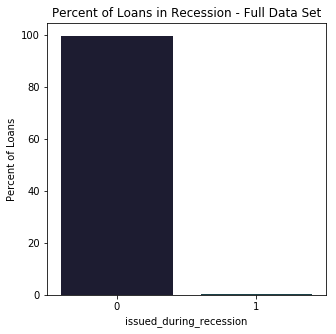

In [22]:
plt.figure(figsize = (5,5))
sns.barplot(x='issued_during_recession', y='percentage_recession', data = filtered_res, palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Percent of Loans")
plt.title('Percent of Loans in Recession - Full Data Set')

Below we investigate whether more of our loans of interest (36-month term with >= 36 months of data are issued during a recession). To filter for these loans of interest we isolate 36 month loans with an issue date at least 36 months before the latest issue date in the data (the most recent data point)

In [23]:
# The latest date in the dataset is Dec 2018 - thus any loan with at least 36 months of data will span min 36 months before this date
max_date_in_data = max(filtered_loan_data_cat_fix_1['issue_d_clean'])
max_date_in_data

Timestamp('2018-12-01 00:00:00')

In [24]:
filtered_loan_data_cat_fix_1['months_of_data'] = ((max_date_in_data - filtered_loan_data_cat_fix_1['issue_d_clean'])/np.timedelta64(1, 'M')).astype(int)

In [25]:
loan_data_36_cat = filtered_loan_data_cat_fix_1[(filtered_loan_data_cat_fix_1['term_ 36 months'] == 1) & (filtered_loan_data_cat_fix_1['months_of_data'] >= 36.0)]

In [26]:
loan_data_36_cat.shape[0]

621163

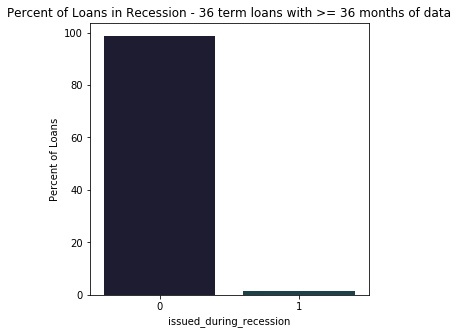

In [27]:
filtered_rec_36 = loan_data_36_cat.groupby('issued_during_recession')['int_rate'].count().reset_index()
filtered_rec_36 = filtered_rec_36.copy()
filtered_rec_36['percentage_recession'] = filtered_rec_36['int_rate'] / sum(filtered_rec_36['int_rate']) * 100
plt.figure(figsize = (5,5))
sns.barplot(x='issued_during_recession', y='percentage_recession', data = filtered_rec_36, palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Percent of Loans")
plt.title('Percent of Loans in Recession - 36 term loans with >= 36 months of data')

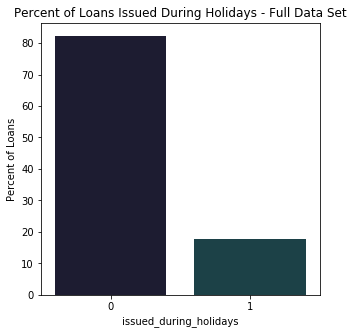

In [28]:
# visualize issued_during_holidays variable
filtered_res = filtered_loan_data_cat_fix_1.groupby('issued_during_holidays')['int_rate'].count().reset_index()
filtered_res = filtered_res.copy()
filtered_res['percentage_recession'] = filtered_res['int_rate'] / sum(filtered_res['int_rate']) * 100
plt.figure(figsize = (5,5))
sns.barplot(x='issued_during_holidays', y='percentage_recession', data = filtered_res, palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Percent of Loans")
plt.title('Percent of Loans Issued During Holidays - Full Data Set')

In [29]:
# we don't need issue_d anymore
filtered_loan_data_cat_fixed = filtered_loan_data_cat_fix_1[filtered_loan_data_cat_fix_1.columns.difference(['issue_d', 'issue_d_clean'])]

#### Section 1C: Exploring Numerical Variables - Managing Outliers

In [30]:
#summarize numerical variables
filtered_loan_data_cat_fixed[numerical_vars].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06
mean,15043.9,15038.6,13.0921,78051.5,18.8242,16658.9,11827.2
std,9188.07,9186.24,4.83136,112718,14.1833,22945.4,9890.39
min,500,500,5.31,0,-1,0,0
25%,8000,8000,9.49,46000,11.89,5951,4274.47
50%,12900,12850,12.62,65000,17.84,11325,9065.12
75%,20000,20000,15.99,93000,24.49,20247,16712.6
max,40000,40000,30.99,1.1e+08,999,2.90484e+06,63296.9


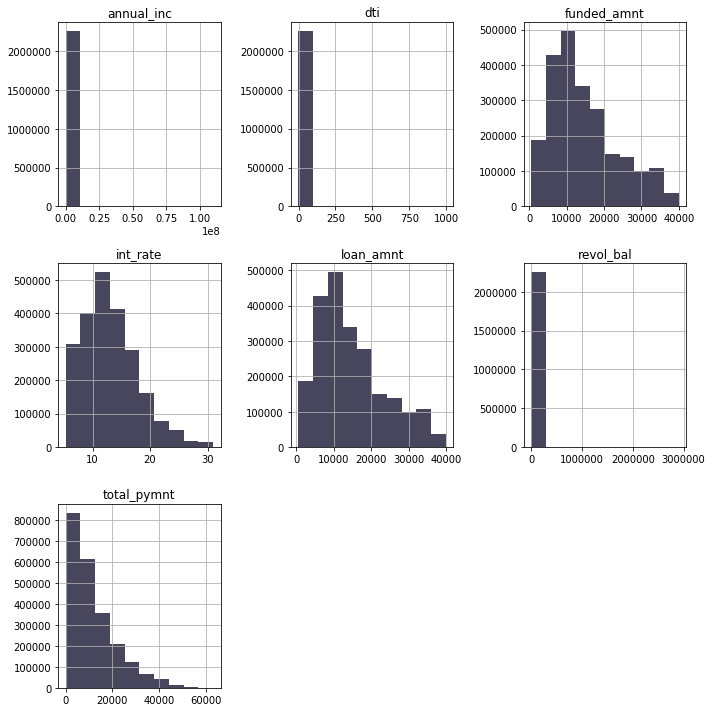

In [31]:
# distributions of numerical variables
axh = filtered_loan_data_cat_fixed[numerical_vars].hist(figsize=(10,10), alpha = 0.8)
figsize=(20, 10)
plt.tight_layout()
plt.show()

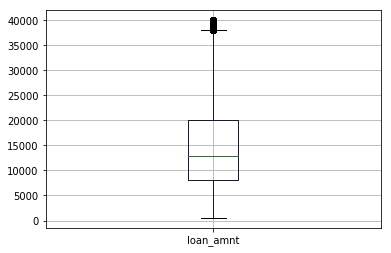

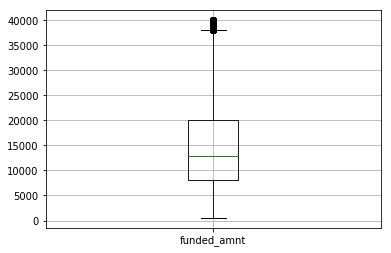

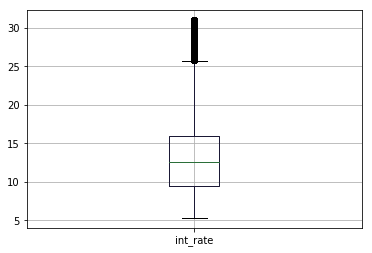

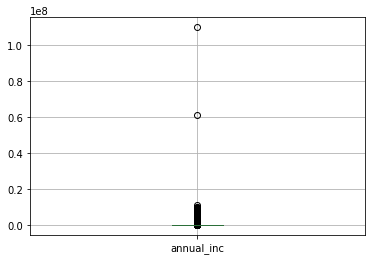

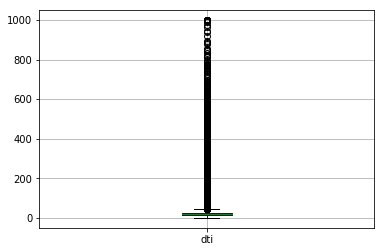

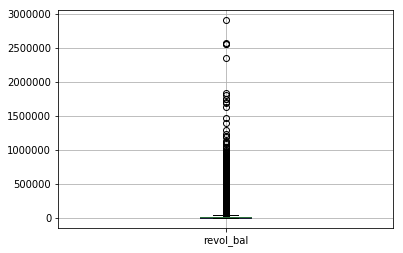

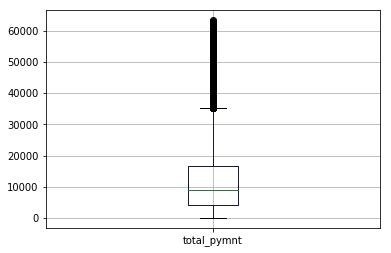

In [32]:
# box plots of each numerical variable
for column in filtered_loan_data_cat_fixed[numerical_vars]:
    plt.figure()
    filtered_loan_data_cat_fixed.boxplot([column])

The pictures above shows the highest incidence of outliers in revolving balance, dti, annual income and total payment. This result is logical in that these variables are most sensitive to individual customer situations and are thus most impacted by outlier customers

In [33]:
# create version of dataset with outliers removed using 1.5 IQR rule
filtered_loan_data_no_outliers = filtered_loan_data_cat_fixed.copy()
for col in numerical_vars:
    Q1 = filtered_loan_data_no_outliers[col].quantile(0.25)
    Q3 = filtered_loan_data_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    filtered_loan_data_no_outliers = filtered_loan_data_no_outliers[(filtered_loan_data_no_outliers[col] >= (Q1-1.5*IQR)) & (filtered_loan_data_no_outliers[col] <= (Q3+1.5*IQR))] 

In [34]:
# droping observations with outliers removes ~ 16% of the data
(filtered_loan_data_cat_fixed.shape[0] - filtered_loan_data_no_outliers.shape[0]) / filtered_loan_data_cat_fixed.shape[0] * 100

16.468691469012413

Given, the relatively large % of the data that is removed when dropping all observations with outliers, we cannot simply remove outliers as they may be a reflect significant underlying features of the data. Given the high-incidence of outliers, the following configurations will be tested in the predictive model: a model with all outliers, a model excluding all outliers, a model with outliers winsorized 5% on the right (maximum) side. A 5% threshold is chosen as given the high outlier precense in the data set, a relatively high winsorization threshold is needed for winsorization to have the intended effect.

In [35]:
filtered_loan_data_winsorized = filtered_loan_data_cat_fixed.copy()
for col in numerical_vars: 
     filtered_loan_data_winsorized[col] = sc.stats.mstats.winsorize(filtered_loan_data_winsorized[col], limits=(None, 0.05))

In [36]:
# now we have three datasets - regular, no outliers and winsorized
filtered_loan_data_regular = filtered_loan_data_cat_fixed.copy()
dfs_list = [filtered_loan_data_regular, filtered_loan_data_no_outliers, filtered_loan_data_winsorized]

In [37]:
continuous_vars = np.append(numerical_vars, ['months_since_issue'])

#### Section 1D: Cross Variable Exploration

First, we explore relationships between each of the covariates themselves and then we explore the relationship between covariates and loan default.

In [38]:
filtered_loan_data_corr = filtered_loan_data_regular[filtered_loan_data_regular.columns.difference(['grade_CP', 'term_CP', 'loan_status_CP'])]

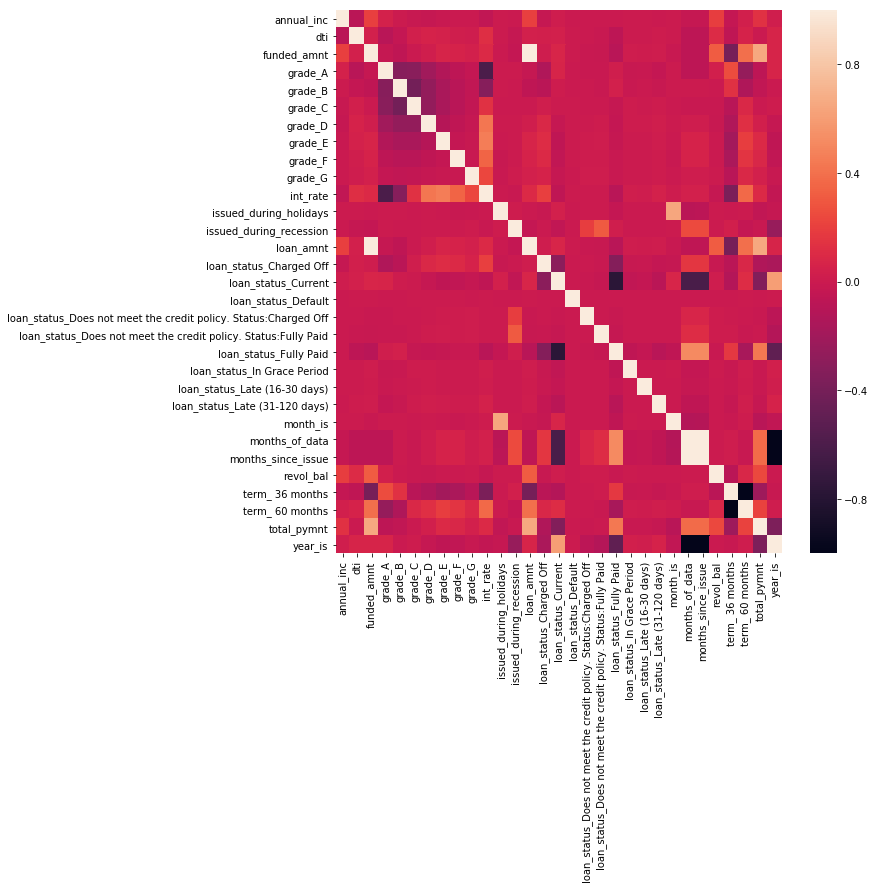

In [39]:
# heat map of correlation between variables
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(np.corrcoef(filtered_loan_data_corr.T), ax=ax)
ax.set_xticklabels(filtered_loan_data_corr.columns, rotation='vertical')
ax.set_yticklabels(filtered_loan_data_corr.columns, rotation='horizontal')
plt.show()

The heatmap above displayes interesting and potentially collinear relationships between interest rate and grade and loan amount and funded amount. We investigate both below.

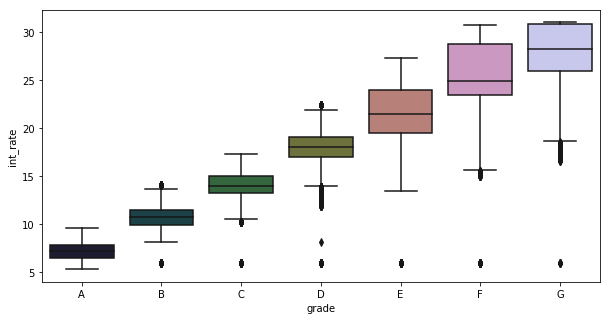

In [40]:
# relationship between interest rate and grade
# These appear quite colinear, especially after excluding outliers
# grade likely isn't needed in the model if interest rate is already there
plt.figure(figsize = (10,5))
sns.boxplot(x="grade", y="int_rate", data=filtered_loan_data, order = ['A', 'B','C', 'D', 'E', 'F', 'G'])
plt.show()

The above chart shows a clear relationship between grade and interest rate (lower grade is asssociated with higher interest rate). This implies that the two are likely collinear and both don't need to be in our predictive model. We keep interest rate as it is captures risk from being in a higher sub-grade within a grade (e.g. the worse subgrade borrowers in Grade G with the highest interet rates may be the most likely to default). Moreover, the distinction between bordeline loans between grades may be minimal and using the continuous variable interest rate reduces this concern.

https://www.lendingclub.com/foliofn/rateDetail.action. 

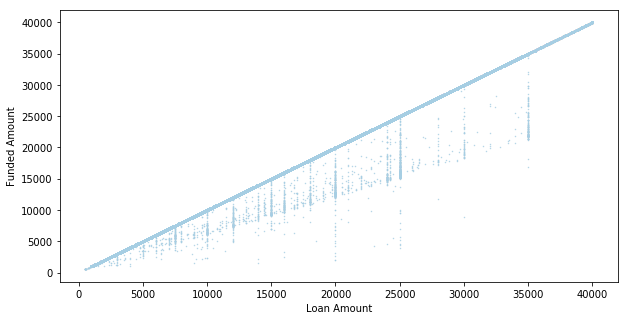

In [41]:
sns.set_palette(sns.color_palette("Paired"))

y = filtered_loan_data_regular['funded_amnt'].values
x = filtered_loan_data_regular['loan_amnt'].values

plt.figure(figsize = (10,5))
plt.scatter(x=x, y=y, s = 0.2)
plt.ylabel('Funded Amount')
plt.xlabel('Loan Amount')

In [42]:
# Loan Amount and Funded Amount are virtually identical for all observations - varying for less than 0.1% of observations
(filtered_loan_data_regular['funded_amnt']!=filtered_loan_data_regular['loan_amnt']).value_counts()

False    2256888
True        2065
dtype: int64

The scatter plot of loan and funded amount show a strong correlation between the two and they are identical for virtually all (99.9%) of observations. Thus only one should be used in our model. We use loan_amnt.

Next, we explore the relationship between our covariates and the dependent variable (default rate) to gauge which covariates may be good individual predictors of default. First, we need to create the dependent variable and isolate our population of interest for studying defaults (36-month term with >= 36 months of data)

In [43]:
# isolate 36 month term loans that have have >= 36 months of data
loan_data_36 = filtered_loan_data_regular[(filtered_loan_data_regular['term_ 36 months'] == 1) & (filtered_loan_data_regular['months_of_data'] >= 36.0)]

In [44]:
# create fully paid variable
loan_data_36 = loan_data_36.copy()
loan_data_36['Fully_Paid'] = [1 if x in ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'] else 0 for x in loan_data_36['loan_status_CP']]

In [45]:
# create default dependent variable as loans not fully paid
loan_data_36 = loan_data_36.copy()
loan_data_36['Default'] = [1 if x == 0 else 0 for x in loan_data_36['Fully_Paid']]

In [46]:
loan_data_36.shape, loan_data_36[loan_data_36['Default']==1].shape[0]

((621163, 36), 86839)

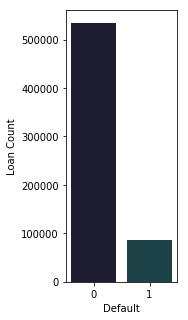

In [47]:
# How are defaults distributed?
# ~86-14 ratio between defaults and not
plt.figure(figsize = (2,5))
sns.barplot(x='Default', y='int_rate', data = loan_data_36.groupby('Default')['int_rate'].count().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Loan Count")

As shown in the figure above, defaults occur ~14% of the time in the dataset with 36-month loans that were issued at least 36-months ago. Furthermore, the distribution of continuous co-variates by defaults and non-defaults below show that interest rate, revolving balance and dti to be more promising predictors of default as these factors show the least overlap in their distribution for defaults and non-defaults and do not leak information into the model.

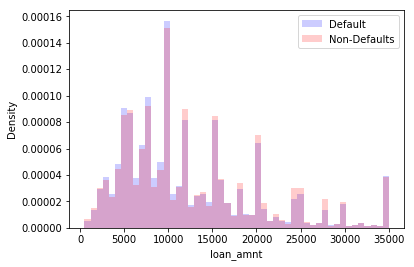

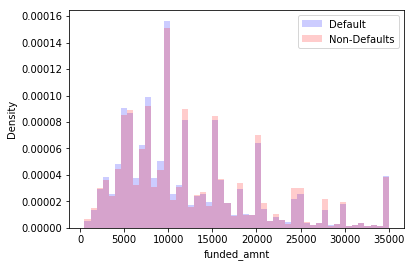

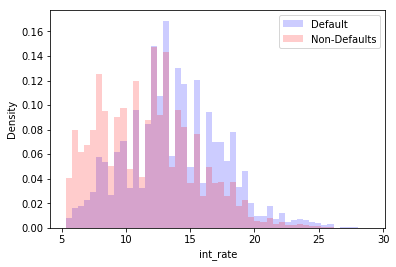

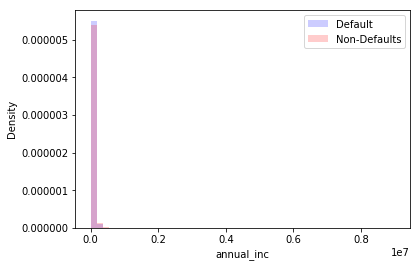

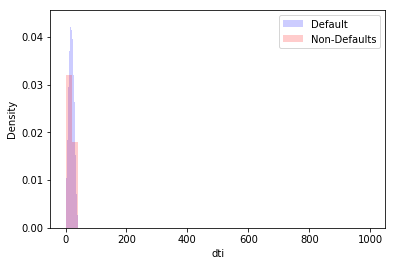

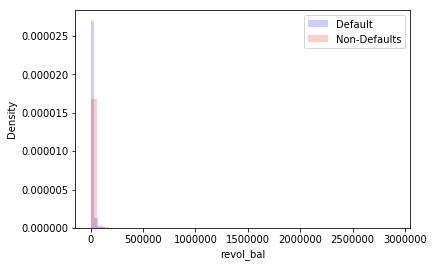

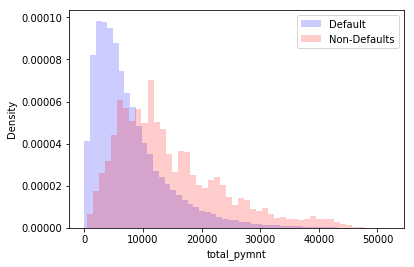

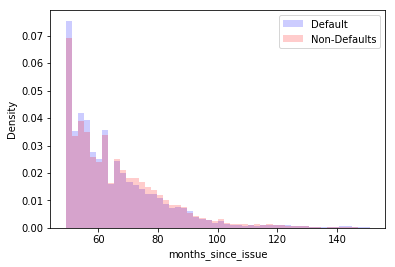

In [48]:
# plot distribution of covariates by default status
for var in continuous_vars:
    defaults = loan_data_36[loan_data_36['Default']==1][var]
    non_defaults = loan_data_36[loan_data_36['Default']==0][var]
    plt.hist(defaults, bins = 50, alpha=0.2, label='Default', color = 'blue', normed=True)
    plt.hist(non_defaults, bins = 50, alpha=0.2, label='Non-Defaults', color = 'red', normed= True)
    plt.legend(loc='upper right')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

The figure below also shows a clear relationship between defaulting and grades; lower grade loans are more likely to default.

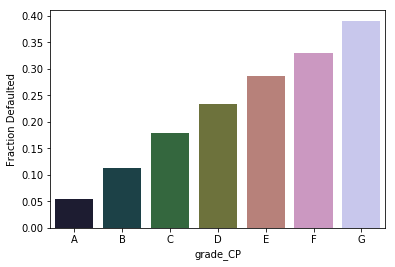

In [49]:
# loan defaults by grade - with status being colinear and term limited to 36 months, this is the only categorical variable that may be in the model
sns.barplot(x='grade_CP', y='Default', data = loan_data_36.groupby('grade_CP')['Default'].mean().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Fraction Defaulted")

The figures below show that default rate is significantly higher for loans issued during a recession

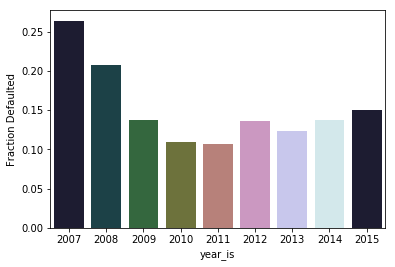

In [50]:
sns.barplot(x='year_is', y='Default', data = loan_data_36.groupby('year_is')['Default'].mean().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Fraction Defaulted")

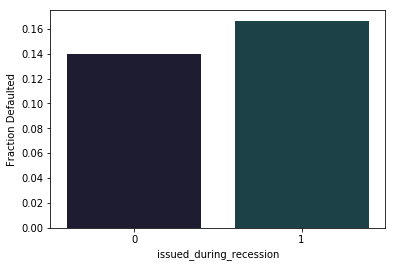

In [51]:
sns.barplot(x='issued_during_recession', y='Default', data = loan_data_36.groupby('issued_during_recession')['Default'].mean().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Fraction Defaulted")

The below figures shows no significant difference between default rates of loans issued during the holidays and those issued during other months

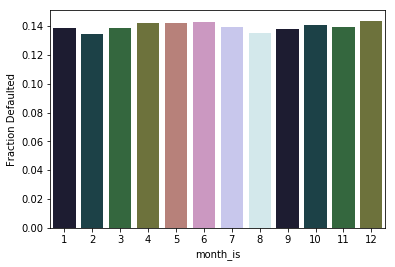

In [52]:
sns.barplot(x='month_is', y='Default', data = loan_data_36.groupby('month_is')['Default'].mean().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Fraction Defaulted")

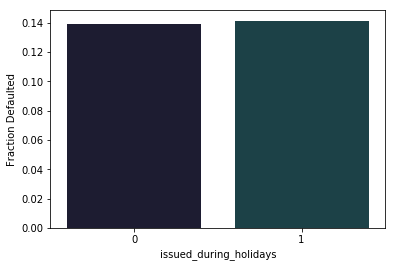

In [53]:
sns.barplot(x='issued_during_holidays', y='Default', data = loan_data_36.groupby('issued_during_holidays')['Default'].mean().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Fraction Defaulted")

# Part 2: Business Analysis

Part 2 consists of three sections:
#### Section 2A: Percentage of Loans Fully Paid
#### Section 2B: Cohort analysis - Percent Default
#### Section 2C: Cohort analysis - Annualized Rate of Return

For the business analysis, I use the full dataset as these metrics will generally not be skewed by outliers (especially the percent defaults which are a 0 or 1 variable). Additionally, with a high incidence of outliers in the data set, they likely capture a representative feature of the data and should be included.

#### Section 2A: Percentage of Loans Fully Paid

In [54]:
# ~86% of loans fully paid
loan_data_36[loan_data_36['Fully_Paid'] == 1].shape[0] / loan_data_36.shape[0] * 100

86.01993357621107

~86% of loans with 36 month terms that have existed for 36 or more months have been fully paid

#### Section 2B: Cohort Analysis - Percent Default

In [55]:
default_cohorts = pd.crosstab(loan_data_36['grade_CP'], loan_data_36['year_is'], values = loan_data_36['Default'], aggfunc='mean')
default_cohorts

year_is,2007,2008,2009,2010,2011,2012,2013,2014,2015
grade_CP,,,,,,,,,
A,0.054054,0.059748,0.067332,0.043631,0.063990,0.072352,0.045612,0.053831,0.054583
B,0.163265,0.173401,0.121799,0.096257,0.105676,0.125677,0.097859,0.107239,0.119793
C,0.241135,0.210345,0.152819,0.135266,0.155243,0.175722,0.152958,0.171950,0.195156
D,0.313131,0.264916,0.179927,0.185954,0.180809,0.211478,0.203930,0.221745,0.263264
E,0.310000,0.263158,0.217532,0.196429,0.205882,0.218868,0.233055,0.270309,0.329524
F,0.480769,0.342342,0.266667,0.296703,0.240741,0.184466,0.268092,0.294949,0.424798
G,0.485714,0.325581,0.327273,0.352941,0.400000,0.166667,0.266667,0.363128,0.467742


In [56]:
# The maximum value of ~49% is for Grade G loans issued in 2007
max(default_cohorts.max().values)

0.48571428571428571

As shown in the heat map below, Grade G loans issued in 2007 have the highest rate of default of ~49%. This result is logical as it occurs for a low grade loan in a recessionary year. A visualization of defaults by grade and year issued shows higher default rates in recessionary years and for lower grade loans

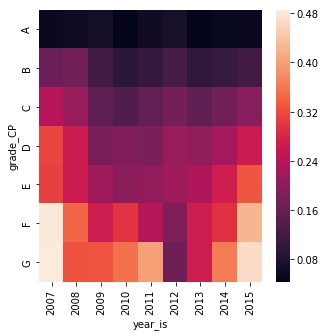

In [57]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(default_cohorts, ax=ax)

#### Section 2C: Cohort Analysis - Rate of Return

In [58]:
loan_data_36 = loan_data_36.copy()
loan_data_36['ROR'] = (loan_data_36['total_pymnt'] / loan_data_36['funded_amnt']) ** (1/3) - 1

In [59]:
returns_crosstab = pd.crosstab(loan_data_36['grade_CP'], loan_data_36['year_is'], values = loan_data_36['ROR'], aggfunc='mean')
returns_crosstab

year_is,2007,2008,2009,2010,2011,2012,2013,2014,2015
grade_CP,,,,,,,,,
A,0.026455,0.023488,0.021457,0.021672,0.014997,0.015804,0.024873,0.021949,0.019434
B,-0.001857,-0.000276,0.014551,0.022018,0.022047,0.023704,0.030172,0.025857,0.018160
C,-0.008002,-0.003972,0.012092,0.022437,0.017920,0.022367,0.030388,0.021428,0.011119
D,-0.013119,-0.018201,0.014316,0.012707,0.022120,0.024695,0.028380,0.017577,0.002413
E,-0.015043,-0.003274,-0.000189,0.014385,0.025079,0.032345,0.028680,0.013843,-0.010299
F,-0.079793,-0.044362,0.002747,-0.007690,0.022408,0.033400,0.020588,0.018980,-0.026656
G,-0.044028,-0.007825,0.003100,-0.007570,-0.020228,0.043012,-0.007625,0.005299,-0.044741


As shown in the heat map below, returns generally improve with higher grade (e.g. going from G to A) and are lowest during the most recent recession (2007-2009)

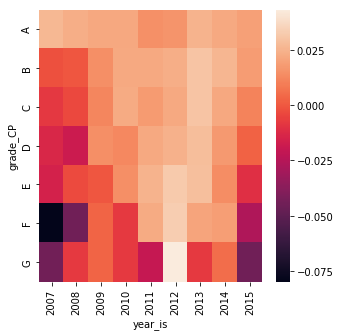

In [60]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(returns_crosstab, ax=ax)

# Part 3: Modeling

Part 3 consists of four sections:

#### Section 3A: Generate train and test set and standardize data
#### Section 3B: Cross-validate and run logisitic regression
#### Section 3C: Analyze effectivness using ROC curves

#### Section 3A: Generate train and test set and standardize data based on training

75% of the data is randomly assigned as the training set – on which the predictive model will be calibrated and calculated and 25% is assigned as the test set on which on the model will be tested for prediction accuracy. 

This train-test split will prevent over-fitting (e.g. good model performance on a subset of data but not generalizing well).

##### Features EXCLUDED from the model for the reasons detailed below:

-Total Payment - Leaks information on default probability into model as it is not known at origination

-Months_since_issue - Leaks information on default probability into model as it is not known at origination

-Grade - collinear with interest rate

-Funded amount - collinear with loan amount

##### Features INCLUDED in the model that are relevant (correlated with defaults), non-collinear with each other and do not leak information:

-Annual income

-Loan amount

-Interest rate

-DTI

-Revolving balance

-Whether loan was issued during recession
    

In [61]:
# create training and test sets
train_dfs_dict = {}
test_dfs_dict = {}
key_list = []
for df in dfs_list:
    #filter to scope of 36 month term loans with >= 36 months of data
    df_filtered = df[(df['term_ 36 months'] == 1) & (df['months_of_data'] >=36)]
    df_filtered = df_filtered.copy()
    #create dependent variable
    df_filtered['default'] = [1 if (x==0) & (y==0) else 0 for x,y in zip(df_filtered['loan_status_Fully Paid'], df_filtered['loan_status_Does not meet the credit policy. Status:Fully Paid'])]
    # see cell above for reasoning behind selected features
    features = ['default','annual_inc', 'loan_amnt', 'issued_during_recession', 'int_rate', 'dti', 'revol_bal']
    df_filtered_features = df_filtered[features]
    np.random.seed(9001)
    msk = np.random.rand(len(df_filtered_features)) < 0.75
    data_train =  df_filtered_features[msk]
    data_test =  df_filtered_features[~msk]
    key =[x for x in globals() if globals()[x] is df][0]
    if key == 'df':
        key = 'filtered_data_regular'
    key_list.append(key)
    train_dfs_dict[key] = data_train
    test_dfs_dict[key] = data_test

In [62]:
# standardize numerical variables
std_train_dfs_dict = {}
std_test_dfs_dict = {}
continuous_vars = ['annual_inc', 'loan_amnt', 'dti', 'revol_bal', 'int_rate']
for key in key_list:
    train_df = train_dfs_dict[key]
    test_df = test_dfs_dict[key]
    mean = train_df[continuous_vars].mean()
    std = train_df[continuous_vars].std()
    std_train_df = train_df.copy()
    std_test_df = test_df.copy()
    std_train_df[continuous_vars] = (std_train_df[continuous_vars] - mean)/std
    std_test_df[continuous_vars] = (std_test_df[continuous_vars] - mean)/std
    std_train_dfs_dict[key] = std_train_df
    std_test_dfs_dict[key] = std_test_df

#### Section 3B: Cross-validate and run logistic regression

Logistic Regression CV runs 5-fold cross validation to optimize its parameters for prediction accuracy and then runs the cross-validated model on the training data. The classifier is run on the model with outliers, model without outliers and model with winsorized outliers.


In [63]:
# store dependent variable by dataset (regular, no outliers, winsorized)
y_train_dict = {}
y_test_dict = {}
for key in key_list: 
    y_train_dict[key] = std_train_dfs_dict[key]['default']
    y_test_dict[key] = std_test_dfs_dict[key]['default']

In [64]:
# create dictionaries to store classifier results by dataset (regular, no outliers, winsorized)
train_accuracy_dict = {}
test_accuracy_dict = {}
train_preds_dict = {}
test_preds_dict = {}
roc_curve_dict = {}
pred_proba_dict = {}

In [65]:
# run logistic regression for each dataset and store outputs (regular, no outliers, winsorized)
for key in key_list:
    logregcv = LogisticRegressionCV()
    # isolate X, Y for train and test
    X_train = std_train_dfs_dict[key][std_train_dfs_dict[key].columns.difference(['default'])]
    y_train = y_train_dict[key]
    X_test = std_test_dfs_dict[key][std_test_dfs_dict[key].columns.difference(['default'])]
    y_test = y_test_dict[key]
    # fit and predict logistic regression
    logregcv.fit(X_train, y_train)
    y_hat_train = logregcv.predict(X_train)
    y_hat_test = logregcv.predict(X_test)
    # store predictions
    train_preds_dict[key] =  y_hat_train
    test_preds_dict[key] =  y_hat_test
    pred_proba_dict[key] = logregcv.predict_proba(X_test)
    # calculate accuracy
    train_accuracy_dict[key] = accuracy_score(y_train, y_hat_train)
    test_accuracy_dict[key] = accuracy_score(y_test, y_hat_test)
    # store outputs for ROC curve
    preds = logregcv.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    roc_curve_dict[key] = (fpr, tpr, roc_auc)

#### Section 3C: Analyze effectiveness of Model

#### Section 3C-1: Showing accuracy is not the appropriate evaluation metric

In order to establish the effectivness of this model we need to establish a baseline. Given the relatively low incidence of default, a good baseline is guessing no default for all loans. In comparing accuracies of our logistic regression classifier, the accuracy rates are nearly identical to the baseline of assuming no defaults. However, accuracy is not the most appropriate metric given the imbalanced nature of the data (86% fully paid, 14% defaults). The naive classifier of assuming no defaults does not know anything about the data and is simply getting 'lucky'. If the dataset was more balanced (e.g. more defaults in a recession, more defaults due lending club increasing risk tolerance), such a naive classifer would surely perform worse. Thus, accuracy is not the appropriate metric to evaluate our classifer's ability to distinguish between defaults and non-fefaults against a 'lucky' baseline and we turn to alternative metrics below.

In [66]:
# Accuracy of baseline assuming no defaults
for key in key_list:
    print("Train accuracy of no defaults baseline: " + key, accuracy_score(y_train_dict[key], [0 for y in y_train_dict[key]]))
    print("Test accuracy of no defaults baseline : " + key, accuracy_score(y_test_dict[key], [0 for y in y_test_dict[key]]))

Train accuracy of no defaults baseline: filtered_loan_data_regular 0.860085588339
Test accuracy of no defaults baseline : filtered_loan_data_regular 0.860541496212
Train accuracy of no defaults baseline: filtered_loan_data_no_outliers 0.853641747498
Test accuracy of no defaults baseline : filtered_loan_data_no_outliers 0.852763507851
Train accuracy of no defaults baseline: filtered_loan_data_winsorized 0.860085588339
Test accuracy of no defaults baseline : filtered_loan_data_winsorized 0.860541496212


In [67]:
# Accuracy of Logistic regression models
print("Train accuracy for Logistic Regression: " + str(train_accuracy_dict))
print("Test accuracy for Logistic Regression: " + str(test_accuracy_dict))

Train accuracy for Logistic Regression: {'filtered_loan_data_regular': 0.86008987848171858, 'filtered_loan_data_no_outliers': 0.85379632492174518, 'filtered_loan_data_winsorized': 0.86008773341055589}
Test accuracy for Logistic Regression: {'filtered_loan_data_regular': 0.86053504368361966, 'filtered_loan_data_no_outliers': 0.85282180201843549, 'filtered_loan_data_winsorized': 0.86054149621236564}


#### Section 3C-2: Evaluating using ROC curves

ROC curves show a more optimistic picture for our classifier. A naive classifer would move along the dashed line the plot with an AUC of 0.5, wheras our classifer has a max AUC of 0.67, suggesting that across various default thresholds that our model has a greater ability to separate defaults and non-defaults than a naive guess of no defaults. However, an AUC of around 0.67 is not stellar and there is likely room for improvement in this model, likely with the addition of more relevant variables (e.g. credit score, assets, period of unemployment, history of default, etc.)

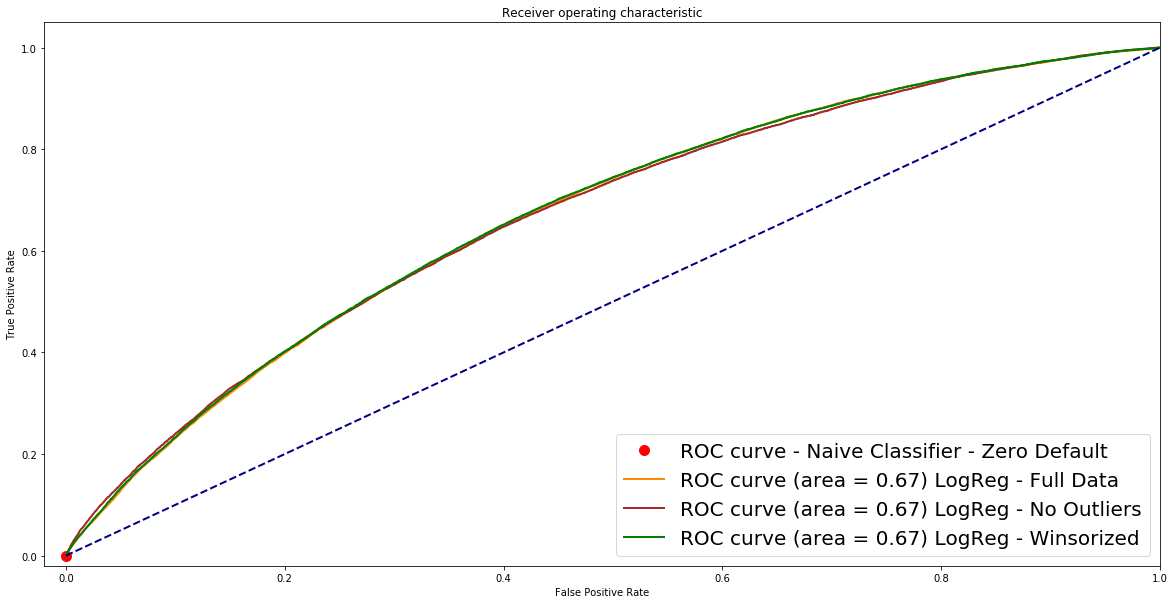

In [68]:
plt.figure(figsize=(20,10))
lw = 2
# naive classifier - assuming no defaults
plt.plot([0], [0], marker='o', markersize=10, lw = 0, color="red", label ='ROC curve - Naive Classifier - Zero Default')
# model with full data
plt.plot(roc_curve_dict[key_list[0]][0], roc_curve_dict[key_list[0]][1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) LogReg - Full Data' % roc_curve_dict[key_list[0]][2])
# model with no outliers
plt.plot(roc_curve_dict[key_list[1]][0], roc_curve_dict[key_list[1]][1], color='brown',
         lw=lw, label='ROC curve (area = %0.2f) LogReg - No Outliers' % roc_curve_dict[key_list[1]][2])
# model with winsorization
plt.plot(roc_curve_dict[key_list[2]][0], roc_curve_dict[key_list[2]][1], color='green',
         lw=lw, label='ROC curve (area = %0.2f) LogReg - Winsorized' % roc_curve_dict[key_list[2]][2])
# naive - zero defaults
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size':20})
plt.show()

#### Section 3C-3: Evaluating using Precision Recall Curves

As ROC curves account for the correctness of both positive and negative predictions, the ROC AUC is not completely immune from the imbalanced nature of the data as correctly predicting negatives (non-defaults) is easier than predicting positives (non-defaults). Precision recall curves that only account for the model's effectivness in making positive predictions (default = 1 in our case) may be another important method of evaluating effectiveness in predicting defaults. The precision recall curves below show that our model is somewhat more skilled at making positive predicting defaults compared to a naive baseline of predicting all defaults, likely requiring additional variables to be more effective.

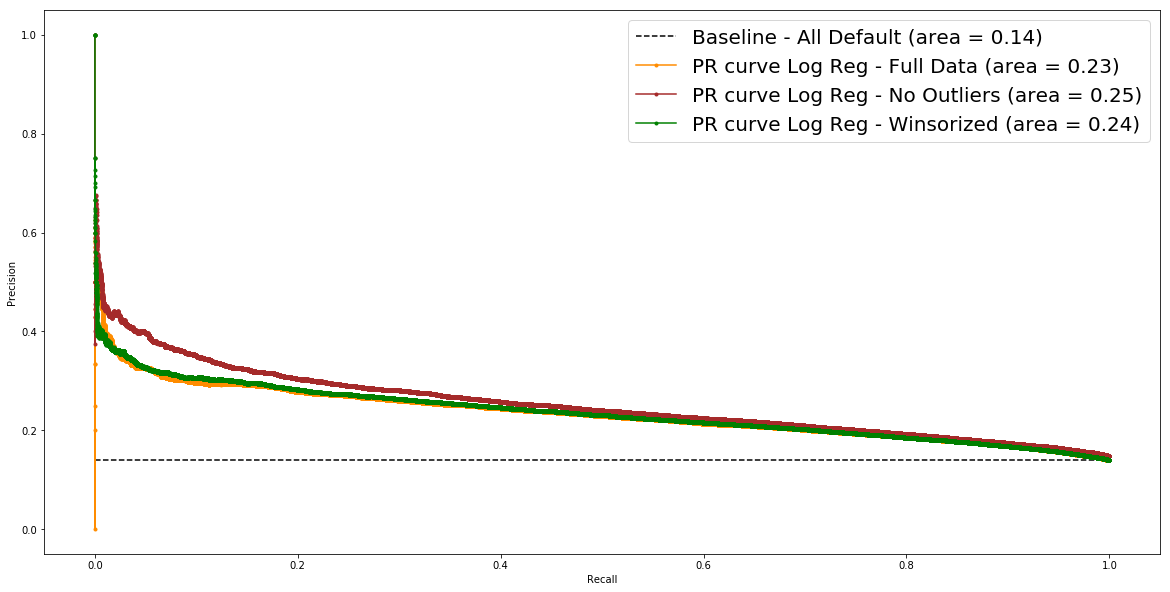

In [69]:
plt.figure(figsize=(20,10))
# plot baseline - all defaults
plt.plot([0, 1], [0.14, 0.14], linestyle='--', label='Baseline - All Default (area = 0.14)', color = 'black')
# plot the precision-recall curves for logistic regression
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test_dict[key_list[0]], pred_proba_dict[key_list[0]][:, 1])
plt.plot(lr_recall, lr_precision, marker='.', label='PR curve Log Reg - Full Data (area = %0.2f)' % metrics.auc(lr_recall, lr_precision), color = 'darkorange')
lr_precision2, lr_recall2, _ = metrics.precision_recall_curve(y_test_dict[key_list[1]], pred_proba_dict[key_list[1]][:, 1])
plt.plot(lr_recall2, lr_precision2, marker='.', label='PR curve Log Reg - No Outliers (area = %0.2f)' % metrics.auc(lr_recall2, lr_precision2), color = 'brown')
lr_precision3, lr_recall3, _ = metrics.precision_recall_curve(y_test_dict[key_list[2]], pred_proba_dict[key_list[2]][:, 1])
plt.plot(lr_recall3, lr_precision3, marker='.', label='PR curve Log Reg - Winsorized (area = %0.2f)' % metrics.auc(lr_recall3, lr_precision3), color = 'green')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right", prop={'size':20})

# show the plot
plt.show()